In [1]:
!pip install pandas numpy scikit-learn nltk


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [18]:
# Load dataset
df = pd.read_csv("/content/agentic_ai_performance_dataset_20250622.csv")

# Preview
df.head()


,agent_id,agent_type,model_architecture,deployment_environment,task_category,task_complexity,autonomy_level,success_rate,accuracy_score,efficiency_score,...,error_recovery_rate,multimodal_capability,edge_compatibility,privacy_compliance_score,bias_detection_score,timestamp,data_quality_score,performance_index,cost_efficiency_ratio,autonomous_capability_score
0,AG_01012,Project Manager,PaLM-2,Server,Text Processing,5,3,0.4788,0.6455,0.6573,...,0.4999,False,False,0.9390,0.8061,2024-12-24 04:16:15,0.9510,0.58236,50.203448,64.993
1,AG_00758,Marketing Assistant,Mixtral-8x7B,Hybrid,Decision Making,6,5,0.4833,0.5660,0.5844,...,0.5580,False,False,0.8281,0.7816,2024-12-24 04:16:15,0.7822,0.53844,69.030769,89.060
2,AG_00966,QA Tester,Mixtral-8x7B,Server,Communication,2,4,0.8116,0.8395,0.7650,...,0.9196,False,False,0.7450,0.8214,2024-12-24 04:16:15,0.7621,0.80599,127.934921,124.372
3,AG_00480,Code Assistant,CodeT5+,Hybrid,Creative Writing,8,6,0.3574,0.4888,0.4742,...,0.3809,True,False,0.9653,0.8684,2024-12-24 04:16:15,0.8117,0.43186,21.066341,86.663
4,AG_01050,QA Tester,Falcon-180B,Edge,Planning & Scheduling,3,4,0.5706,0.7137,0.7209,...,0.6717,False,True,0.9042,0.8417,2024-12-24 04:16:15,0.7762,0.65862,57.271304,87.019


In [20]:
# Display basic information
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nBasic Statistics:\n{df.describe()}")


DATASET OVERVIEW
Shape: (5000, 26)

Columns: ['agent_id', 'agent_type', 'model_architecture', 'deployment_environment', 'task_category', 'task_complexity', 'autonomy_level', 'success_rate', 'accuracy_score', 'efficiency_score', 'execution_time_seconds', 'response_latency_ms', 'memory_usage_mb', 'cpu_usage_percent', 'cost_per_task_cents', 'human_intervention_required', 'error_recovery_rate', 'multimodal_capability', 'edge_compatibility', 'privacy_compliance_score', 'bias_detection_score', 'timestamp', 'data_quality_score', 'performance_index', 'cost_efficiency_ratio', 'autonomous_capability_score']

Data Types:
agent_id                        object
agent_type                      object
model_architecture              object
deployment_environment          object
task_category                   object
task_complexity                  int64
autonomy_level                   int64
success_rate                   float64
accuracy_score                 float64
efficiency_score               

In [21]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create safety score (inverse of unsafe actions)
df['safety_score'] = (
    df['accuracy_score'] * 0.3 +
    df['error_recovery_rate'] * 0.3 +
    (1 - df['human_intervention_required'].astype(int)) * 0.2 +
    df['privacy_compliance_score'] * 0.1 +
    df['bias_detection_score'] * 0.1
)

# Hallucination risk indicator (lower is better)
df['hallucination_risk'] = (
    (1 - df['accuracy_score']) * 0.4 +
    (1 - df['success_rate']) * 0.3 +
    (1 - df['data_quality_score']) * 0.3
)

# Create reliability index
df['reliability_index'] = (
    df['success_rate'] * 0.25 +
    df['accuracy_score'] * 0.25 +
    df['error_recovery_rate'] * 0.25 +
    df['efficiency_score'] * 0.25
)

print("New Features Created:")
print(df[['safety_score', 'hallucination_risk', 'reliability_index']].describe())


New Features Created:
       safety_score  hallucination_risk  reliability_index
count   5000.000000         5000.000000        5000.000000
mean       0.527691            0.364338           0.554707
std        0.136444            0.098735           0.136901
min        0.348060            0.092620           0.327675
25%        0.428277            0.288895           0.433419
50%        0.495780            0.371765           0.542013
75%        0.569017            0.451500           0.661231
max        0.938070            0.524850           0.906275


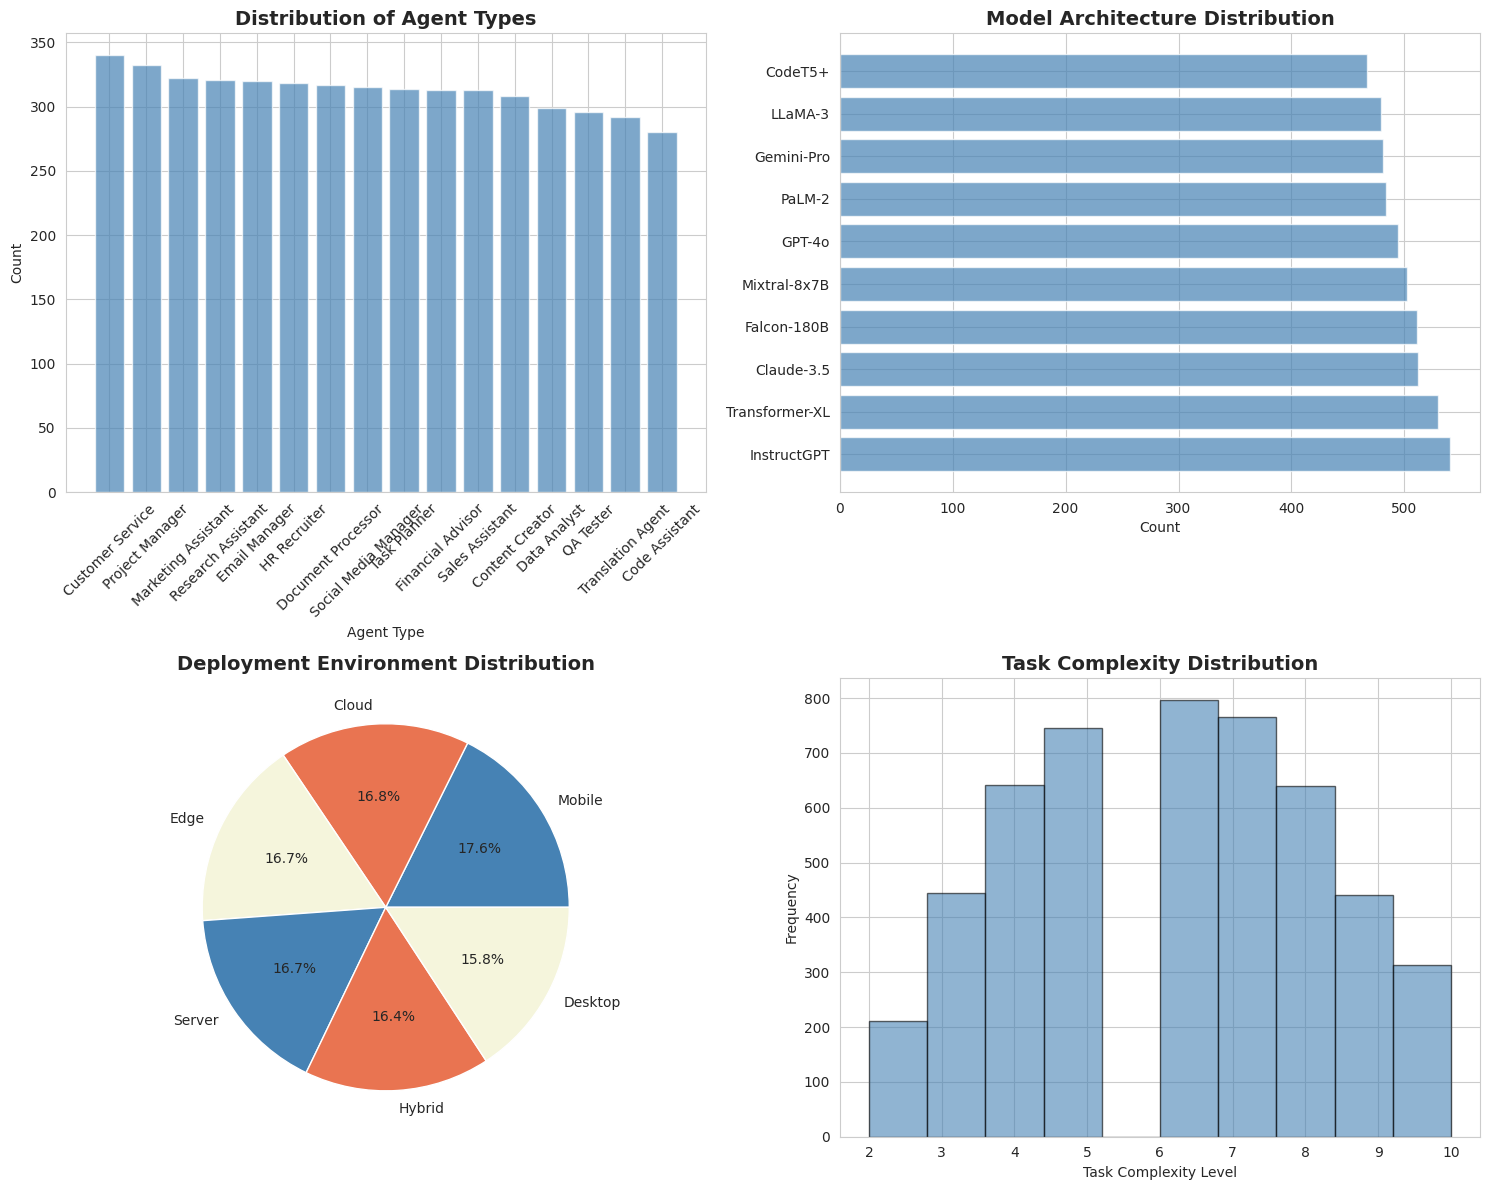

In [31]:
# Agent Type Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Agent Type Distribution
agent_counts = df['agent_type'].value_counts()
axes[0, 0].bar(agent_counts.index, agent_counts.values, color='steelblue', alpha=0.7)
axes[0, 0].set_title('Distribution of Agent Types', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Agent Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Model Architecture Distribution
model_counts = df['model_architecture'].value_counts()
axes[0, 1].barh(model_counts.index, model_counts.values, color='steelblue', alpha=0.7)
axes[0, 1].set_title('Model Architecture Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Count')

# 3. Deployment Environment
deploy_counts = df['deployment_environment'].value_counts()
axes[1, 0].pie(deploy_counts.values, labels=deploy_counts.index, autopct='%1.1f%%',
               colors=['#4682B4', '#E97451', '#F5F5DC'])
axes[1, 0].set_title('Deployment Environment Distribution', fontsize=14, fontweight='bold')

# 4. Task Complexity Distribution
axes[1, 1].hist(df['task_complexity'], bins=10, color='steelblue', alpha=0.6, edgecolor='black')
axes[1, 1].set_title('Task Complexity Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Task Complexity Level')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


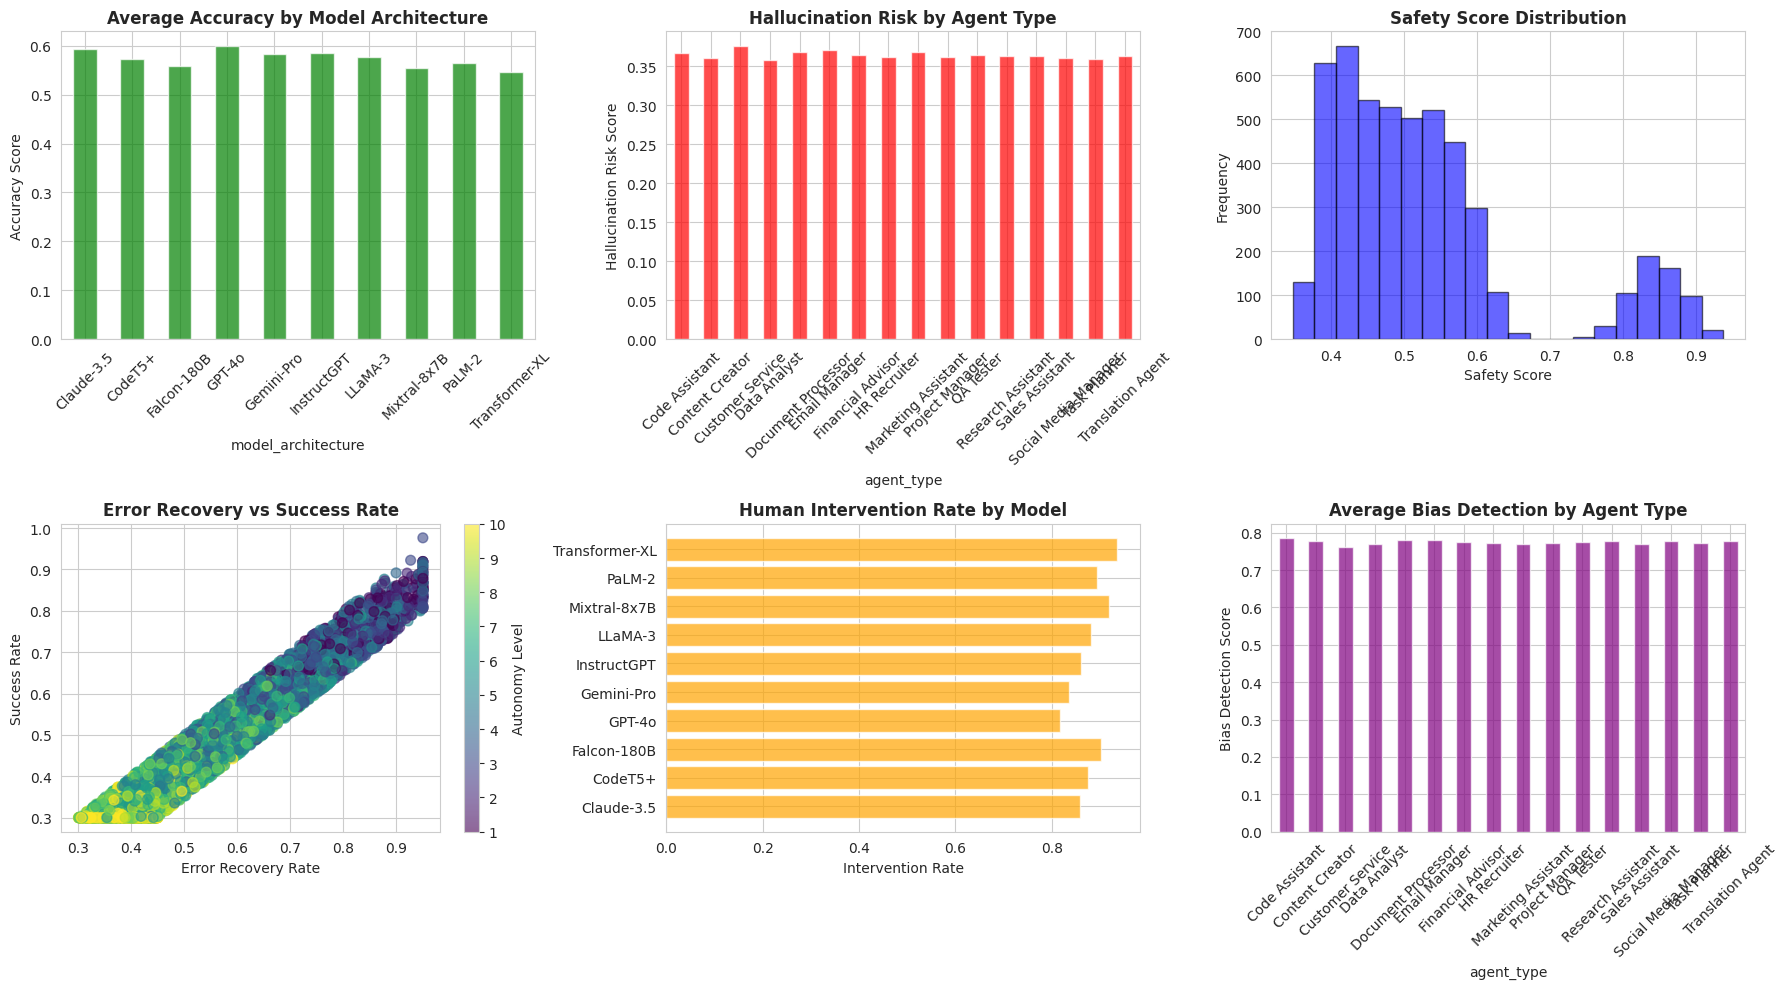

In [23]:
# Key metrics related to hallucinations and safety
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy Score by Model Architecture
df.groupby('model_architecture')['accuracy_score'].mean().plot(
    kind='bar', ax=axes[0, 0], color='green', alpha=0.7)
axes[0, 0].set_title('Average Accuracy by Model Architecture', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# Hallucination Risk by Agent Type
df.groupby('agent_type')['hallucination_risk'].mean().plot(
    kind='bar', ax=axes[0, 1], color='red', alpha=0.7)
axes[0, 1].set_title('Hallucination Risk by Agent Type', fontweight='bold')
axes[0, 1].set_ylabel('Hallucination Risk Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Safety Score Distribution
axes[0, 2].hist(df['safety_score'], bins=20, color='blue', alpha=0.6, edgecolor='black')
axes[0, 2].set_title('Safety Score Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Safety Score')
axes[0, 2].set_ylabel('Frequency')

# Error Recovery Rate vs Success Rate
axes[1, 0].scatter(df['error_recovery_rate'], df['success_rate'],
                   c=df['autonomy_level'], cmap='viridis', alpha=0.6, s=50)
axes[1, 0].set_title('Error Recovery vs Success Rate', fontweight='bold')
axes[1, 0].set_xlabel('Error Recovery Rate')
axes[1, 0].set_ylabel('Success Rate')
axes[1, 0].colorbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label='Autonomy Level')

# Human Intervention Analysis
intervention_rate = df.groupby('model_architecture')['human_intervention_required'].mean()
axes[1, 1].barh(intervention_rate.index, intervention_rate.values, color='orange', alpha=0.7)
axes[1, 1].set_title('Human Intervention Rate by Model', fontweight='bold')
axes[1, 1].set_xlabel('Intervention Rate')

# Bias Detection Score
df.groupby('agent_type')['bias_detection_score'].mean().plot(
    kind='bar', ax=axes[1, 2], color='purple', alpha=0.7)
axes[1, 2].set_title('Average Bias Detection by Agent Type', fontweight='bold')
axes[1, 2].set_ylabel('Bias Detection Score')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [24]:
# Group by model architecture for statistical comparison
print("\n" + "="*80)
print("STATISTICAL ANALYSIS BY MODEL ARCHITECTURE")
print("="*80)

grouped_stats = df.groupby('model_architecture').agg({
    'accuracy_score': ['mean', 'std'],
    'success_rate': ['mean', 'std'],
    'hallucination_risk': ['mean', 'std'],
    'safety_score': ['mean', 'std'],
    'error_recovery_rate': ['mean', 'std'],
    'human_intervention_required': 'mean',
    'performance_index': ['mean', 'std']
}).round(4)

print(grouped_stats)

# ANOVA test for accuracy across model architectures
print("\n" + "="*80)
print("ANOVA TEST: Accuracy Score across Model Architectures")
print("="*80)

model_groups = [group['accuracy_score'].values for name, group in df.groupby('model_architecture')]
f_stat, p_value = stats.f_oneway(*model_groups)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# T-test: Human intervention required vs not required
print("\n" + "="*80)
print("T-TEST: Performance with vs without Human Intervention")
print("="*80)

with_intervention = df[df['human_intervention_required'] == True]['accuracy_score']
without_intervention = df[df['human_intervention_required'] == False]['accuracy_score']
t_stat, p_value = stats.ttest_ind(with_intervention, without_intervention)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Mean accuracy (with intervention): {with_intervention.mean():.4f}")
print(f"Mean accuracy (without intervention): {without_intervention.mean():.4f}")



STATISTICAL ANALYSIS BY MODEL ARCHITECTURE
                   accuracy_score         success_rate          \
                             mean     std         mean     std   
model_architecture                                               
Claude-3.5                 0.5931  0.1300       0.5105  0.1613   
CodeT5+                    0.5730  0.1305       0.4883  0.1599   
Falcon-180B                0.5594  0.1185       0.4788  0.1493   
GPT-4o                     0.5996  0.1381       0.5122  0.1755   
Gemini-Pro                 0.5826  0.1332       0.5063  0.1668   
InstructGPT                0.5849  0.1310       0.4970  0.1646   
LLaMA-3                    0.5766  0.1271       0.4924  0.1595   
Mixtral-8x7B               0.5541  0.1166       0.4725  0.1471   
PaLM-2                     0.5646  0.1236       0.4828  0.1560   
Transformer-XL             0.5469  0.1124       0.4674  0.1409   

                   hallucination_risk         safety_score          \
                           

In [25]:
# Interactive scatter plot: Accuracy vs Hallucination Risk
fig = px.scatter(df, x='accuracy_score', y='hallucination_risk',
                 color='model_architecture', size='performance_index',
                 hover_data=['agent_id', 'agent_type', 'autonomy_level'],
                 title='Accuracy vs Hallucination Risk by Model Architecture',
                 labels={'accuracy_score': 'Accuracy Score',
                         'hallucination_risk': 'Hallucination Risk'})
fig.update_layout(width=1000, height=600)
fig.show()

# Safety Score by Autonomy Level
fig = px.box(df, x='autonomy_level', y='safety_score', color='agent_type',
             title='Safety Score Distribution by Autonomy Level and Agent Type',
             labels={'autonomy_level': 'Autonomy Level',
                     'safety_score': 'Safety Score'})
fig.update_layout(width=1000, height=600)
fig.show()

# Performance comparison radar chart
avg_metrics = df.groupby('model_architecture')[['accuracy_score', 'success_rate',
                                                  'error_recovery_rate', 'efficiency_score',
                                                  'safety_score']].mean()

fig = go.Figure()
for model in avg_metrics.index:
    fig.add_trace(go.Scatterpolar(
        r=avg_metrics.loc[model].values,
        theta=['Accuracy', 'Success Rate', 'Error Recovery', 'Efficiency', 'Safety'],
        fill='toself',
        name=model
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    title='Model Architecture Performance Comparison',
    width=800, height=600
)
fig.show()


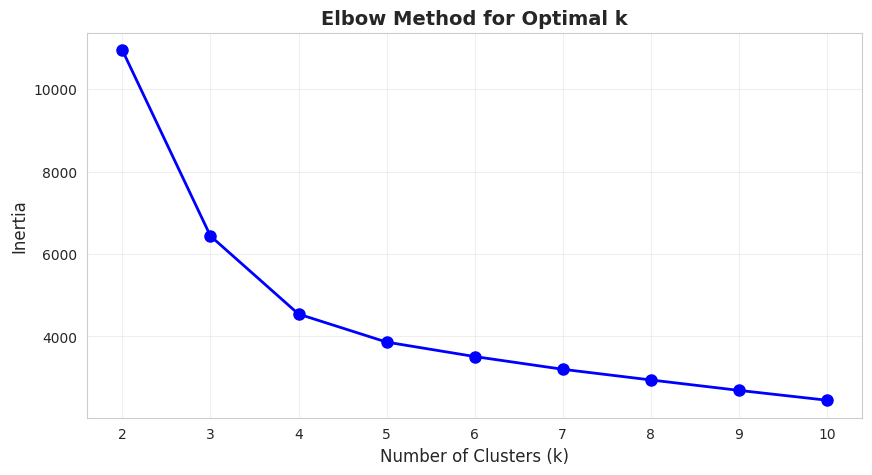


CLUSTER ANALYSIS SUMMARY
         accuracy_score  success_rate  error_recovery_rate  autonomy_level  \
cluster                                                                      
0                0.6731        0.6106               0.6890          4.2742   
1                0.4379        0.3234               0.3964          8.3734   
2                0.7726        0.7703               0.8453          2.9558   
3                0.5582        0.4606               0.5357          6.1636   

         safety_score  hallucination_risk  
cluster                                    
0              0.5715              0.2878  
1              0.4117              0.4699  
2              0.8443              0.1996  
3              0.4896              0.3791  


In [26]:
# K-Means clustering for agent behavior patterns
features_for_clustering = ['accuracy_score', 'success_rate', 'error_recovery_rate',
                           'autonomy_level', 'safety_score', 'hallucination_risk']

X = df[features_for_clustering].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal clusters using elbow method
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# Apply K-Means with optimal k (let's use 4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
fig = px.scatter_3d(df, x='accuracy_score', y='safety_score', z='hallucination_risk',
                    color='cluster', symbol='model_architecture',
                    title='Agent Clustering: Safety vs Accuracy vs Hallucination Risk',
                    labels={'cluster': 'Cluster Group'})
fig.update_layout(width=1000, height=700)
fig.show()

# Cluster characteristics
print("\n" + "="*80)
print("CLUSTER ANALYSIS SUMMARY")
print("="*80)
cluster_summary = df.groupby('cluster')[features_for_clustering].mean().round(4)
print(cluster_summary)


In [27]:
print("\n" + "="*80)
print("KEY FINDINGS SUMMARY FOR CONFERENCE PAPER")
print("="*80)

# 1. Overall performance metrics
print("\n1. OVERALL PERFORMANCE METRICS:")
print(f"   • Average Accuracy Score: {df['accuracy_score'].mean():.4f} (±{df['accuracy_score'].std():.4f})")
print(f"   • Average Success Rate: {df['success_rate'].mean():.4f} (±{df['success_rate'].std():.4f})")
print(f"   • Average Safety Score: {df['safety_score'].mean():.4f} (±{df['safety_score'].std():.4f})")
print(f"   • Average Hallucination Risk: {df['hallucination_risk'].mean():.4f} (±{df['hallucination_risk'].std():.4f})")

# 2. Best performing model
print("\n2. BEST PERFORMING MODEL ARCHITECTURE:")
best_model = df.groupby('model_architecture')['safety_score'].mean().idxmax()
print(f"   • Model: {best_model}")
print(f"   • Average Safety Score: {df[df['model_architecture']==best_model]['safety_score'].mean():.4f}")
print(f"   • Average Accuracy: {df[df['model_architecture']==best_model]['accuracy_score'].mean():.4f}")

# 3. Human intervention insights
print("\n3. HUMAN INTERVENTION INSIGHTS:")
intervention_stats = df.groupby('human_intervention_required').agg({
    'accuracy_score': 'mean',
    'safety_score': 'mean',
    'hallucination_risk': 'mean'
}).round(4)
print(intervention_stats)

# 4. Autonomy level impact
print("\n4. AUTONOMY LEVEL IMPACT:")
autonomy_corr = df[['autonomy_level', 'safety_score', 'hallucination_risk']].corr()['autonomy_level']
print(f"   • Correlation with Safety Score: {autonomy_corr['safety_score']:.4f}")
print(f"   • Correlation with Hallucination Risk: {autonomy_corr['hallucination_risk']:.4f}")

# 5. Error recovery effectiveness
print("\n5. ERROR RECOVERY EFFECTIVENESS:")
high_recovery = df[df['error_recovery_rate'] > 0.7]
low_recovery = df[df['error_recovery_rate'] <= 0.7]
print(f"   • High Recovery (>0.7) Safety Score: {high_recovery['safety_score'].mean():.4f}")
print(f"   • Low Recovery (≤0.7) Safety Score: {low_recovery['safety_score'].mean():.4f}")
print(f"   • Improvement: {((high_recovery['safety_score'].mean() - low_recovery['safety_score'].mean()) / low_recovery['safety_score'].mean() * 100):.2f}%")

print("\n" + "="*80)



KEY FINDINGS SUMMARY FOR CONFERENCE PAPER

1. OVERALL PERFORMANCE METRICS:
   • Average Accuracy Score: 0.5734 (±0.1272)
   • Average Success Rate: 0.4907 (±0.1588)
   • Average Safety Score: 0.5277 (±0.1364)
   • Average Hallucination Risk: 0.3643 (±0.0987)

2. BEST PERFORMING MODEL ARCHITECTURE:
   • Model: GPT-4o
   • Average Safety Score: 0.5536
   • Average Accuracy: 0.5996

3. HUMAN INTERVENTION INSIGHTS:
                             accuracy_score  safety_score  hallucination_risk
human_intervention_required                                                  
False                                0.7706        0.8467              0.2003
True                                 0.5461        0.4836              0.3870

4. AUTONOMY LEVEL IMPACT:
   • Correlation with Safety Score: -0.7148
   • Correlation with Hallucination Risk: 0.7778

5. ERROR RECOVERY EFFECTIVENESS:
   • High Recovery (>0.7) Safety Score: 0.7268
   • Low Recovery (≤0.7) Safety Score: 0.4681
   • Improvement: 55.27%


In [28]:
# Save processed data
df.to_csv('agentic_ai_processed_results.csv', index=False)
print("✓ Processed data saved to 'agentic_ai_processed_results.csv'")

# Save summary statistics
with open('statistical_summary.txt', 'w') as f:
    f.write("NEURAL-SYMBOLIC AGENTIC AI ANALYSIS\n")
    f.write("="*80 + "\n\n")
    f.write(str(grouped_stats))
    f.write("\n\n")
    f.write(str(cluster_summary))
print("✓ Statistical summary saved to 'statistical_summary.txt'")

# Create publication-ready table
pub_table = df.groupby('model_architecture').agg({
    'accuracy_score': ['mean', 'std'],
    'hallucination_risk': ['mean', 'std'],
    'safety_score': ['mean', 'std'],
    'error_recovery_rate': ['mean', 'std']
}).round(3)

pub_table.to_csv('publication_ready_table.csv')
print("✓ Publication table saved to 'publication_ready_table.csv'")

print("\n✅ All analyses complete! Ready for conference paper.")


✓ Processed data saved to 'agentic_ai_processed_results.csv'
✓ Statistical summary saved to 'statistical_summary.txt'
✓ Publication table saved to 'publication_ready_table.csv'

✅ All analyses complete! Ready for conference paper.
